In [37]:
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models, datasets
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2, glob, pandas as pd
from glob import glob
from torch import optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [38]:
train_data_dir = 'dataset/train'
test_data_dir = 'dataset/test'

In [39]:
class COVID_Data(Dataset):
    def __init__(self, folder):
        covid = glob(folder + '/Covid/*.jpeg')
        normal = glob(folder + '/Normal/*.jpeg')
        viral_pneumonia = glob(folder + '/Viral Pneumonia/*.jpeg')
        
        self.fpaths = covid[:] + normal[:] + viral_pneumonia[:]
        self.targets = [0]*len(covid) + [1]*len(normal) + [2]*len(viral_pneumonia)

        self.normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
        
        self.augment = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
        ])

        from random import shuffle, seed; seed(10) 
        combined = list(zip(self.fpaths, self.targets))
        shuffle(combined)
        self.fpaths, self.targets = zip(*combined)

    def __len__(self):
        return len(self.fpaths)

    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        im = cv2.resize(im, (224, 224))
        im = torch.tensor(im / 255).unsqueeze(0)
        im = im.repeat(3, 1, 1)
        im = transforms.ToPILImage()(im)
        im = self.augment(im)
        im = transforms.ToTensor()(im)
        im = self.normalize(im)
        return im.float().to(device), torch.tensor(target).long().to(device)

In [40]:
data = COVID_Data(train_data_dir)
print(len(data))

186


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1, device='cuda:0')


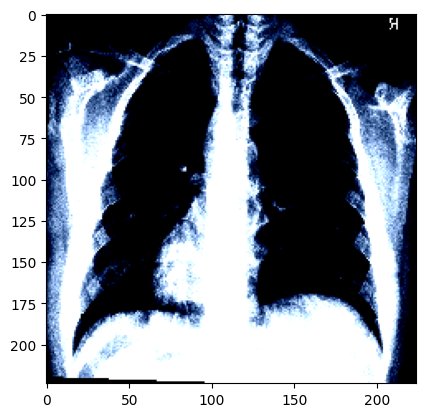

In [41]:
im, label = data[100]
plt.imshow(im.permute(1, 2, 0).cpu())
print(label)

In [42]:
def get_model():
    model = models.resnet18(pretrained = True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    model.fc = nn.Sequential(nn.Flatten(),
                             nn.Linear(512, 128),
                             nn.ReLU(),
                             nn.Dropout(0.2),
                             nn.Linear(128, 3))
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
    return model.to(device), loss_fn, optimizer

In [43]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    opt.step()
    opt.zero_grad()
    return batch_loss.item()

In [44]:
@torch.no_grad
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    predicted_labels = prediction.argmax(dim = 1)
    is_correct = predicted_labels == y
    return is_correct.float().mean().item()

In [45]:
def get_data():
    train = COVID_Data(train_data_dir)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last=True)
    val = COVID_Data(test_data_dir)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last=True)
    return trn_dl, val_dl

In [46]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

/home/saik/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/saik/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [47]:
train_losses, train_accuracies = [], []
val_accuracies = []

for epoch in range(5):
    print(f"epoch {epoch + 1} / 5")
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.append(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.append(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

epoch 1 / 5
epoch 2 / 5
epoch 3 / 5
epoch 4 / 5
epoch 5 / 5


/tmp/ipykernel_5270/2705769700.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


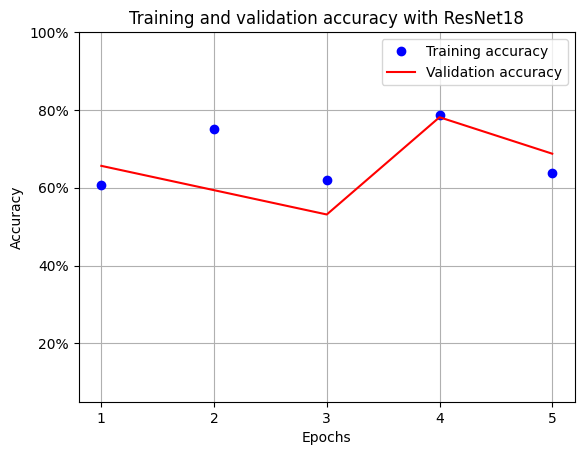

In [48]:
epochs = np.arange(5) + 1
import matplotlib.ticker as mticker
%matplotlib inline

plt.plot(epochs, train_accuracies, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label = 'Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with ResNet18')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.05, 1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()